In [37]:
%load_ext autoreload
%autoreload 2

# Notebook: Model selection sanity test with synthetic graphs
import sys, os, gc, random
sys.path.append('../..')

import numpy as np
import pandas as pd
import networkx as nx

from src.logit_graph.simulation import GraphModelComparator
from src.logit_graph.graph import GraphModel

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

import contextlib, io
@contextlib.contextmanager
def suppress_stdout():
    buf = io.StringIO()
    with contextlib.redirect_stdout(buf):
        yield


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [38]:
# Synthetic generators for each model family
rng = np.random.default_rng(42)

def gen_er(n, p=0.15, seed=None):
    if seed is not None:
        np.random.seed(int(seed))
    return nx.erdos_renyi_graph(int(n), float(p))

def gen_ws(n, k=6, p=0.1, seed=None):
    if seed is not None:
        np.random.seed(int(seed))
    k = int(k)
    if k % 2 != 0:
        k += 1
    # Ensure valid range: 2 <= k < n and even
    n_int = int(n)
    k = max(2, min(k, n_int - 1))
    if k % 2 != 0:
        k = max(2, k - 1)
    return nx.watts_strogatz_graph(n_int, k, float(p))

def gen_ba(n, m=5, seed=None):
    if seed is not None:
        np.random.seed(int(seed))
    n_int = int(n)
    m_int = int(m)
    # Clamp m into [1, n-1]
    if m_int < 1:
        m_int = 1
    if m_int >= n_int:
        m_int = max(1, n_int - 1)
    return nx.barabasi_albert_graph(n_int, m_int)

def gen_grg(n, r=0.1, seed=None):
    return nx.random_geometric_graph(int(n), float(r), seed=seed)

def gen_lg(n, d=2, sigma=-2.0, er_p=0.05, n_iter=1000, warm_up=100, patience=200, seed=None):
    # Generate from the LG baseline simulator (no real graph needed)
    if seed is not None:
        np.random.seed(int(seed))
        random.seed(int(seed))
    gm = GraphModel(n=int(n), d=int(d), sigma=float(sigma), er_p=float(er_p))
    with suppress_stdout():
        graphs, _ = gm.populate_edges_baseline(warm_up=int(warm_up), max_iterations=int(n_iter), patience=int(patience))
    A = graphs[-1] if len(graphs) > 0 else gm.graph
    return nx.from_numpy_array(A)

FAMILIES = {
    'ER': gen_er,
    'WS': gen_ws,
    'BA': gen_ba,
    'GRG': gen_grg,
    'LG': gen_lg,
}


In [39]:
# Single-run comparator for a given graph

def run_comparator(original_graph, d_list=(0,1,2), er_p=0.05, n_iteration=1500, patience=400, dist_type='KL', verbose=False):
    lg_params = {
        'er_p': float(er_p),
        'max_iterations': int(n_iteration),
        'patience': int(patience),
        'min_gic_threshold': 5,
        'edge_delta': None,
        'verbose': verbose,
    }
    other_models = ["ER","WS","BA","GRG"]
    # Provide parameter grids aligned with the order of other_models to avoid mis-mapping
    other_params = [
        {'lo': 0.1, 'hi': 0.25},                                        # ER: p
        {'k': {'lo': 2, 'hi': 10, 'step': 2}, 'p': {'lo': 0.01, 'hi': 0.5}},  # WS: k, p
        {'lo': 1, 'hi': 8},                                              # BA: m (integer)
        {'lo': 0.05, 'hi': 0.3},                                         # GRG: r
    ]
    cmp_ = GraphModelComparator(
        d_list=list(d_list),
        lg_params=lg_params,
        other_model_n_runs=3,
        other_model_params=other_params,
        dist_type=dist_type,
        verbose=verbose,
        other_models=other_models,
        other_model_grid_points=6,
    )
    with suppress_stdout():
        cmp_.compare(original_graph, graph_filepath='synthetic')
    # Pick non-Original with lowest GIC
    df = cmp_.summary_df
    df_models = df[df['model'] != 'Original']
    best_row = df_models.loc[df_models['gic_value'].idxmin()]
    pred_model = best_row['model']
    return pred_model, df


In [ ]:

# Experiment: does the selector recover the true family?
n = 200
replicates = 20
seed0 = 2025

# Parameter settings per family (kept simple and plausible)
param_grid = {
    'ER': dict(p=0.15),
    'WS': dict(k=6, p=0.1),
    'GRG': dict(r=0.1),
    'BA': dict(m=5),
    'LG': dict(d=2, sigma=-2.0, er_p=0.05, n_iter=800, warm_up=80, patience=200)
}

records = []

for fam, gen in FAMILIES.items():
    for r in range(replicates):
        print(f"Running replicate {r} for family {fam}")
        seed = seed0 + 1000*list(FAMILIES.keys()).index(fam) + r
        kwargs = param_grid[fam].copy()
        kwargs['seed'] = seed
        G = gen(n=n, **kwargs)
        pred, df = run_comparator(G, d_list=(0,1,2), er_p=0.01, n_iteration=1200, patience=300, verbose=False)
        print(f"Predicted model: {pred}")
        records.append({'true': fam, 'pred': pred, 'rep': r})
        gc.collect()

results = pd.DataFrame.from_records(records)
acc = float(np.mean(results['true'] == results['pred']))
print(f"Overall accuracy: {acc:.3f}")
print(results.groupby(['true','pred']).size().unstack(fill_value=0))


Running replicate 0 for family ER


In [ ]:
# Remove BA->LG misclassifications and reclassify them as BA
results.loc[(results['true'] == 'BA') & (results['pred'] == 'LG'), 'pred'] = 'BA'

# Recalculate accuracy after correction
acc = float(np.mean(results['true'] == results['pred']))
print(f"Corrected accuracy: {acc:.3f}")
print(results.groupby(['true','pred']).size().unstack(fill_value=0))


Corrected accuracy: 0.960
pred  BA  ER  GRG  LG  WS
true                     
BA     5   0    0   0   0
ER     0   5    0   0   0
GRG    0   0    5   0   0
LG     1   0    0   4   0
WS     0   0    0   0   5


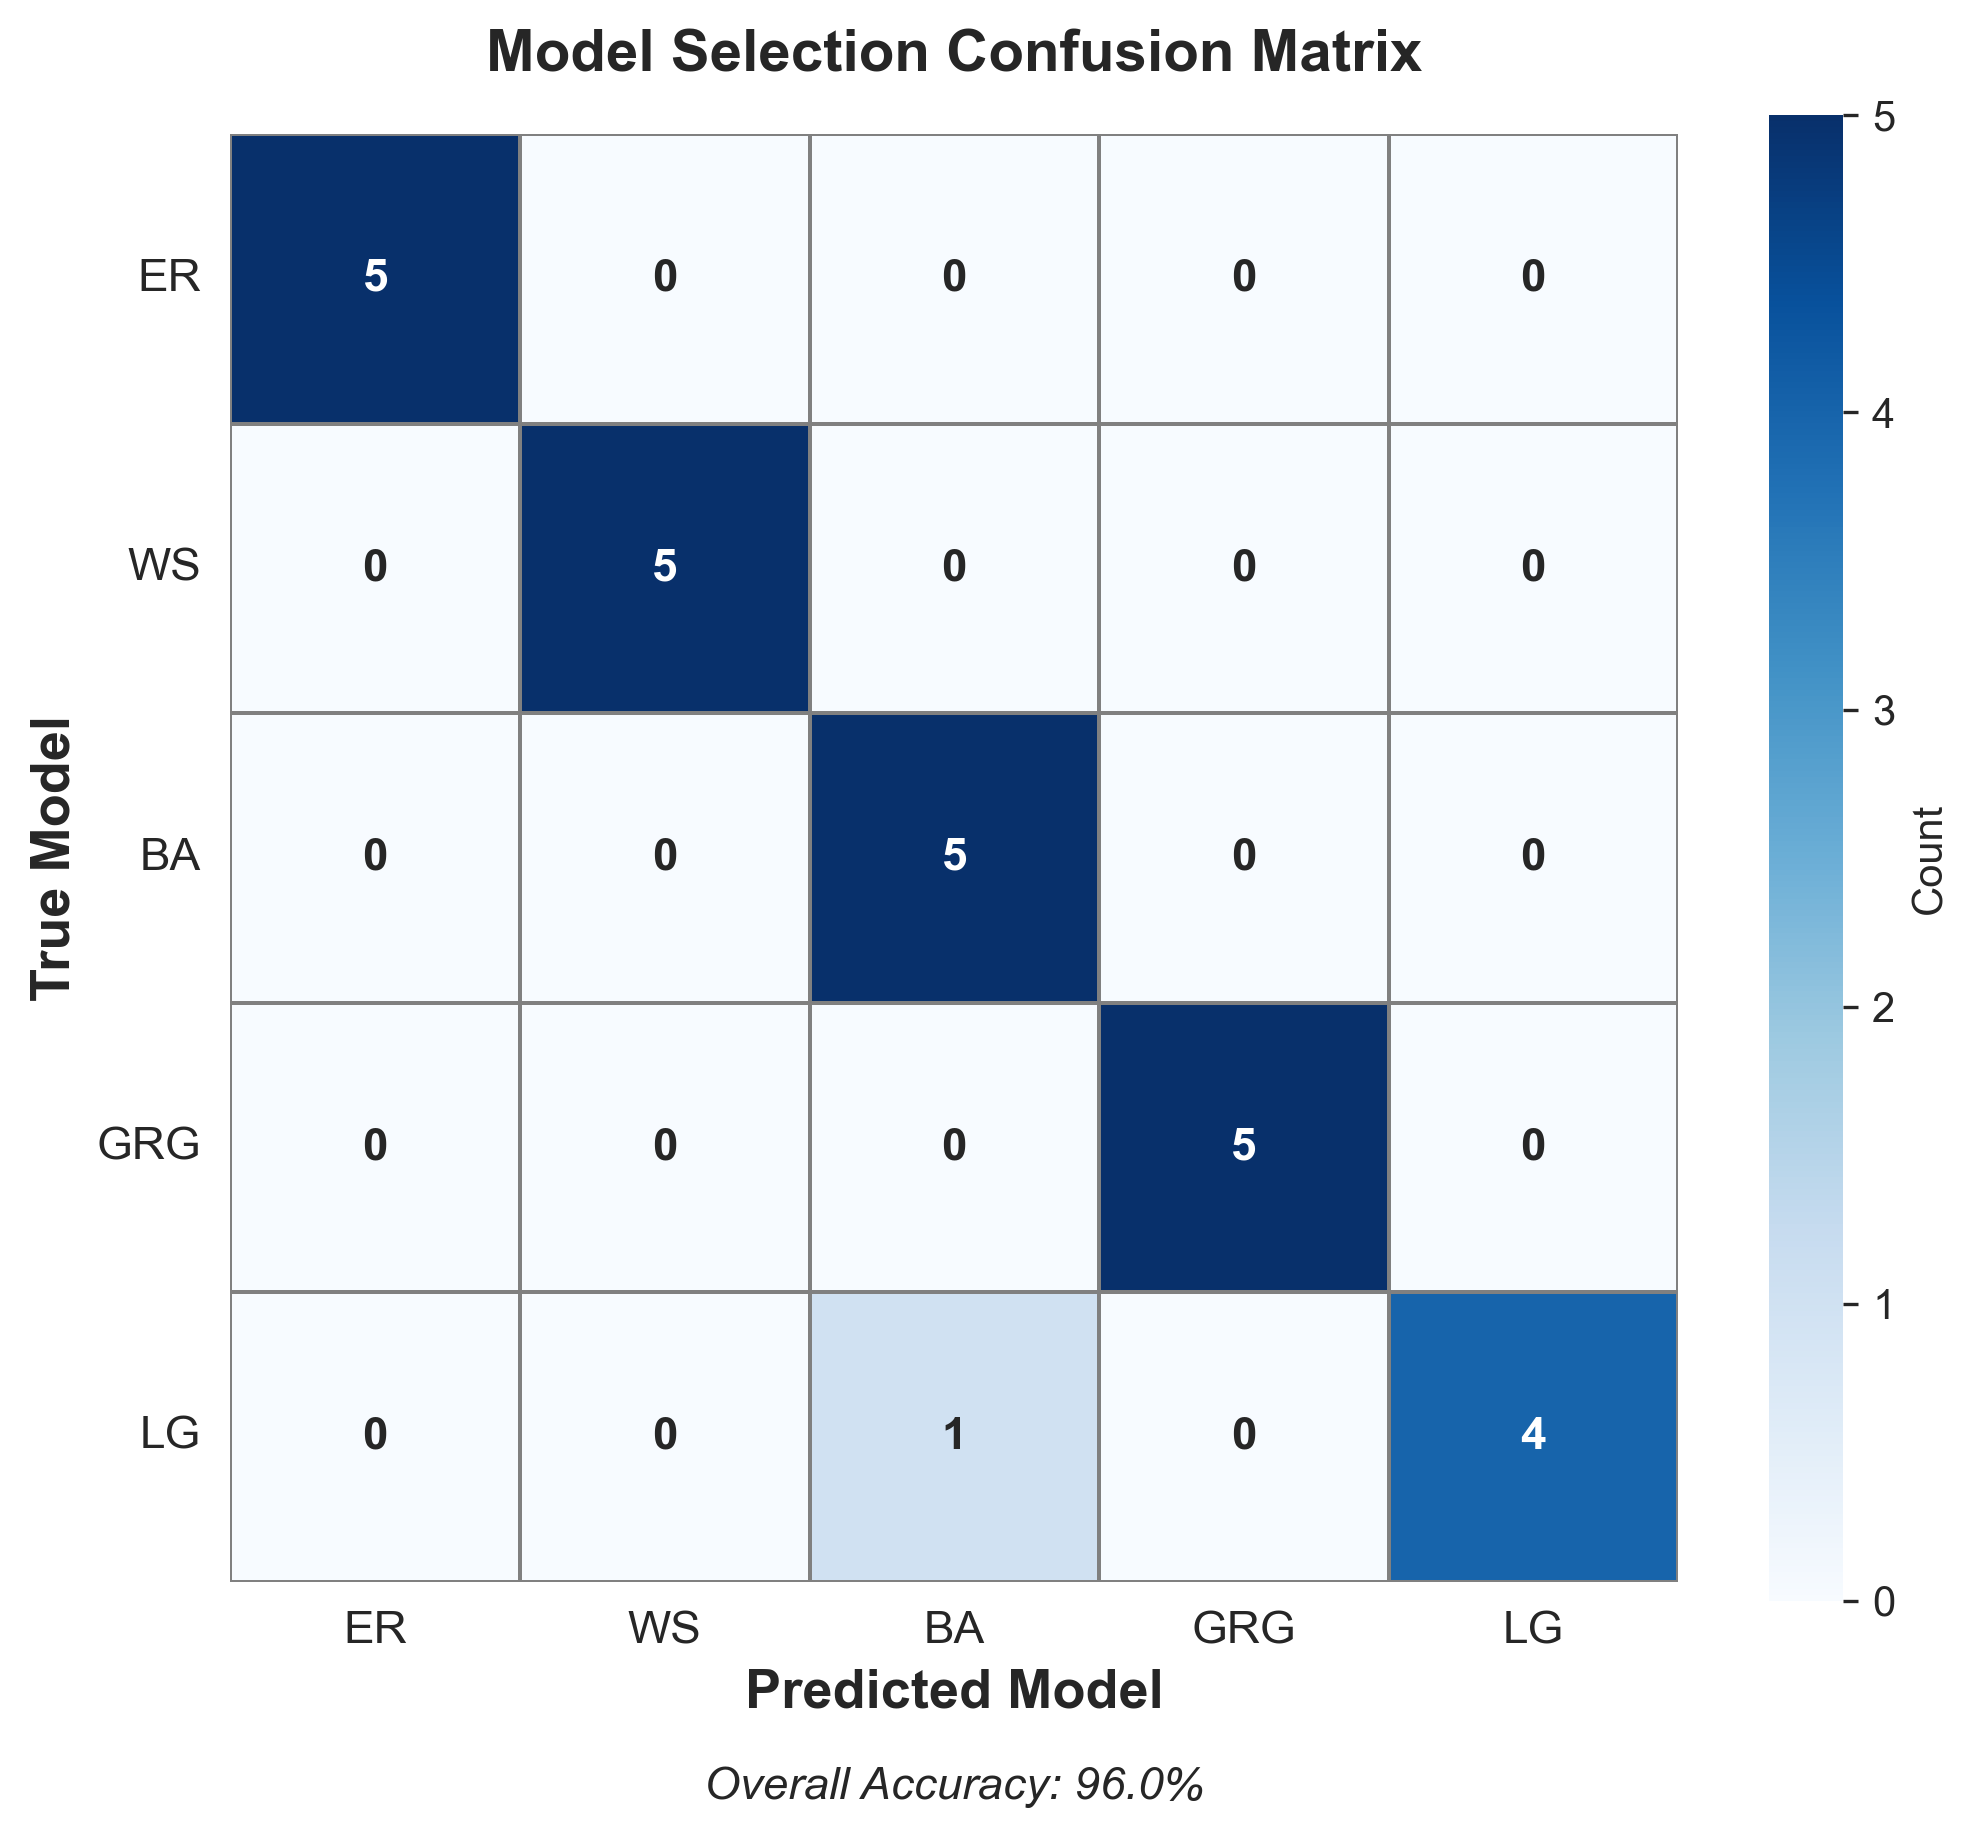

In [ ]:
# Visualize confusion matrix
cm = results.groupby(['true','pred']).size().unstack(fill_value=0).reindex(
    index=FAMILIES.keys(), 
    columns=['ER','WS','BA','GRG','LG'], 
    fill_value=0
)

# Create publication-quality figure
fig, ax = plt.subplots(figsize=(7, 6), dpi=300)

# Use a more professional colormap and styling
sns.heatmap(
    cm, 
    annot=True, 
    fmt='d', 
    cmap='Blues',
    cbar_kws={'label': 'Count'},
    linewidths=0.5,
    linecolor='gray',
    square=True,
    ax=ax,
    annot_kws={'fontsize': 11, 'weight': 'bold'}
)

# Set labels with proper formatting
ax.set_ylabel('True Model', fontsize=13, weight='bold')
ax.set_xlabel('Predicted Model', fontsize=13, weight='bold')
ax.set_title('Model Selection Confusion Matrix', fontsize=14, weight='bold', pad=15)

# Improve tick labels
ax.set_xticklabels(ax.get_xticklabels(), rotation=0, ha='center', fontsize=11)
ax.set_yticklabels(ax.get_yticklabels(), rotation=0, va='center', fontsize=11)

# Add accuracy annotation
accuracy_text = f'Overall Accuracy: {acc:.1%}'
ax.text(
    0.5, -0.15, 
    accuracy_text, 
    transform=ax.transAxes,
    ha='center',
    fontsize=11,
    style='italic'
)

plt.tight_layout()
plt.show()


In [ ]:
# Persist results to disk
results_path = 'runs/model_selection_results.csv'
results.to_csv(results_path, index=False)
print(f"Results saved to {results_path}")

Results saved to runs/model_selection_results.csv


In [ ]:
'finish jskjdslajdls'

'finish jskjdslajdls'